In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from sklearn.manifold import TSNE
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import json
import joblib
import zipfile

Mount drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
print(os.listdir('./drive/MyDrive/Comp432_project/Data'))

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
['Prostate Cancer.zip', 'Animal Faces.zip', 'Colorectal Cancer.zip']


Extract zip from google Drive

In [ ]:
def extract_zip_to_folder(zip_path, data_dir):
    """
    Extracts a zip file into a folder named after the zip file.

    Parameters:
        zip_path (str): Path to the zip file.
        data_dir (str): Base directory where the folder will be created for extraction.
    """
    # Get the name of the folder from the zip file name
    folder_name = os.path.splitext(os.path.basename(zip_path))[0]
    output_dir = os.path.join(data_dir, folder_name)

    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Extract the zip file
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(output_dir)
        print(f"Extracted {zip_path} to {output_dir}")


PC_zip_file = "./drive/MyDrive/Comp432_project/Data/Prostate Cancer.zip"
AF_zip_file = "./drive/MyDrive/Comp432_project/Data/Animal Faces.zip"
data_dir = "./Data"

extract_zip_to_folder(PC_zip_file, data_dir)
extract_zip_to_folder(AF_zip_file, data_dir)

Extracted ./drive/MyDrive/Comp432_project/Data/Prostate Cancer.zip to ./Data/Prostate Cancer
Extracted ./drive/MyDrive/Comp432_project/Data/Animal Faces.zip to ./Data/Animal Faces


In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'The device being used is {device}')

The device being used is cuda


In [ ]:
# Dataset paths for in drive
# dataset_PC_path = "./drive/MyDrive/Comp432_project/Data/Prostate Cancer"
# dataset_AF_path = "./drive/MyDrive/Comp432_project/Data/Animal Faces"

# Dataset paths for google collab runtime
dataset_PC_path = "./Data/Prostate Cancer/Dataset 2/Prostate Cancer"
dataset_AF_path = "./Data/Animal Faces/Dataset 3/Animal Faces"

# Dataset for kaggle
# dataset_PC_path = "/kaggle/input/task2-dataset/Prostate Cancer"
# dataset_AF_path = "/kaggle/input/task2-dataset/Animal Faces"

In [ ]:
# Data transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to ResNet input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

# Load datasets
dataset_PC = ImageFolder(root=dataset_PC_path, transform=transform)
dataset_AF = ImageFolder(root=dataset_AF_path, transform=transform)

print(f"PC Classes: {dataset_PC.classes}")
print(f"AF Classes: {dataset_AF.classes}")

# Split datasets into training and testing sets (70:30 split)
train_size_PC = int(0.7 * len(dataset_PC))
test_size_PC = len(dataset_PC) - train_size_PC
train_dataset_PC, test_dataset_PC = random_split(dataset_PC, [train_size_PC, test_size_PC])

train_size_AF = int(0.7 * len(dataset_AF))
test_size_AF = len(dataset_AF) - train_size_AF
train_dataset_AF, test_dataset_AF = random_split(dataset_AF, [train_size_AF, test_size_AF])

# DataLoaders
batch_size = 32
train_loader_PC = DataLoader(train_dataset_PC, batch_size=batch_size, shuffle=True)
test_loader_PC = DataLoader(test_dataset_PC, batch_size=batch_size, shuffle=False)
train_loader_AF = DataLoader(train_dataset_AF, batch_size=batch_size, shuffle=True)
test_loader_AF = DataLoader(test_dataset_AF, batch_size=batch_size, shuffle=False)

PC Classes: ['gland', 'nongland', 'tumor']
AF Classes: ['cat', 'dog', 'wild']


Ran until here!

In [ ]:
# Path to your saved model
task_1_model_path = "./drive/MyDrive/Comp432_project/task_1/resnet50_colorectal.pth" # uses google drive
# task_1_model_path = "/kaggle/input/task1_resnet50/pytorch/default/1/resnet50_colorectal (1).pth"

# Initialize a ResNet50 model
model_task1 = models.resnet50(weights=None)  # No pre-trained weights

# Replace the classification head to match the checkpoint
# model_task1.fc = nn.Linear(model_task1.fc.in_features, 3)  # 3-class output
model_task1.fc = nn.Identity()

# Load the checkpoint
state_dict = torch.load(task_1_model_path, map_location=device)
model_task1.load_state_dict(state_dict, strict=False)  # Allow mismatch for unused keys

# Set the model to evaluation mode
model_task1 = model_task1.to(device)
model_task1.eval()

<ipython-input-7-7732c4b0568c>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(task_1_model_path, map_location=device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# Feature extraction function
def extract_features(model, dataloader):
    features, labels = [], []
    with torch.no_grad():
        for inputs, lbls in tqdm(dataloader, desc="Extracting Features"):
            inputs = inputs.to(device)
            outputs = model(inputs).cpu().numpy()
            features.append(outputs)
            labels.append(lbls.numpy())
    return np.vstack(features), np.hstack(labels)

In [ ]:
# Extract features for all scenarios
features_PC_task1, labels_PC_task1 = extract_features(model_task1, test_loader_PC)

Extracting Features: 100%|██████████| 57/57 [00:14<00:00,  3.91it/s]


In [ ]:
features_AF_task1, labels_AF_task1 = extract_features(model_task1, test_loader_AF)

Extracting Features: 100%|██████████| 57/57 [00:14<00:00,  3.94it/s]


In [ ]:
# Pre-trained ImageNet model
imagenet_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
imagenet_model.fc = nn.Identity()  # Remove the classification head
imagenet_model = imagenet_model.to(device)
imagenet_model.eval()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 190MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
features_PC_imagenet, labels_PC_imagenet = extract_features(imagenet_model, test_loader_PC)

Extracting Features: 100%|██████████| 57/57 [00:10<00:00,  5.36it/s]


In [ ]:
features_AF_imagenet, labels_AF_imagenet = extract_features(imagenet_model, test_loader_AF)

Extracting Features: 100%|██████████| 57/57 [00:16<00:00,  3.44it/s]


In [ ]:
# t-SNE visualization
def plot_tsne(features, labels, title):
    # Apply t-SNE dimensionality reduction
    tsne = TSNE(n_components=2, random_state=42)
    reduced_features = tsne.fit_transform(features)

    # Create the plot
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels, cmap='tab10', alpha=0.7)
    plt.colorbar(scatter)
    plt.title(title)

    # Save the plot to the specified directory
    # save_dir = f"/kaggle/working/tsne_plots/{title}" #This is just for kaggle
    save_dir = f"./tsne_plots/{title}"
    os.makedirs(save_dir, exist_ok=True)
    plt.savefig(f"{save_dir}/tsne_plot.png")

    # Show the plot
    plt.show()

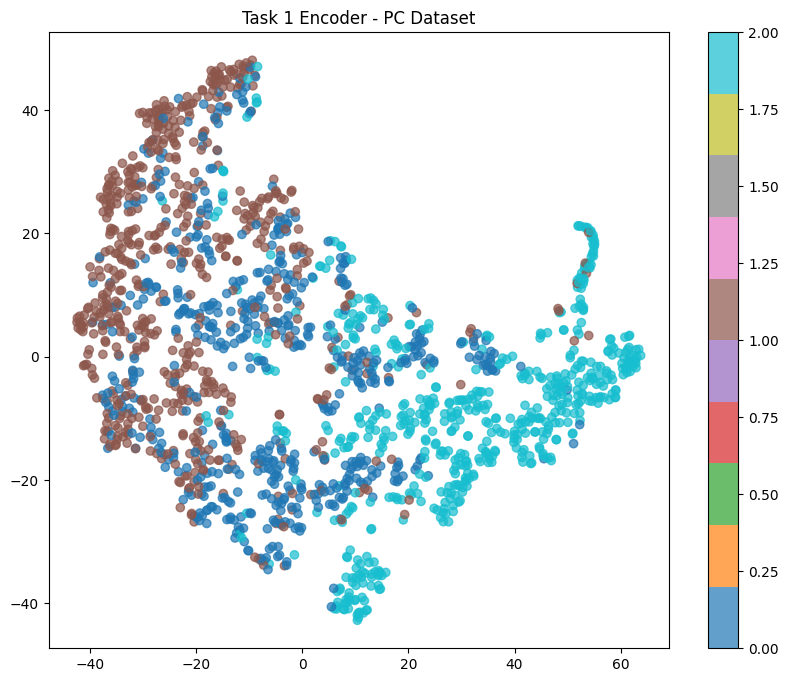

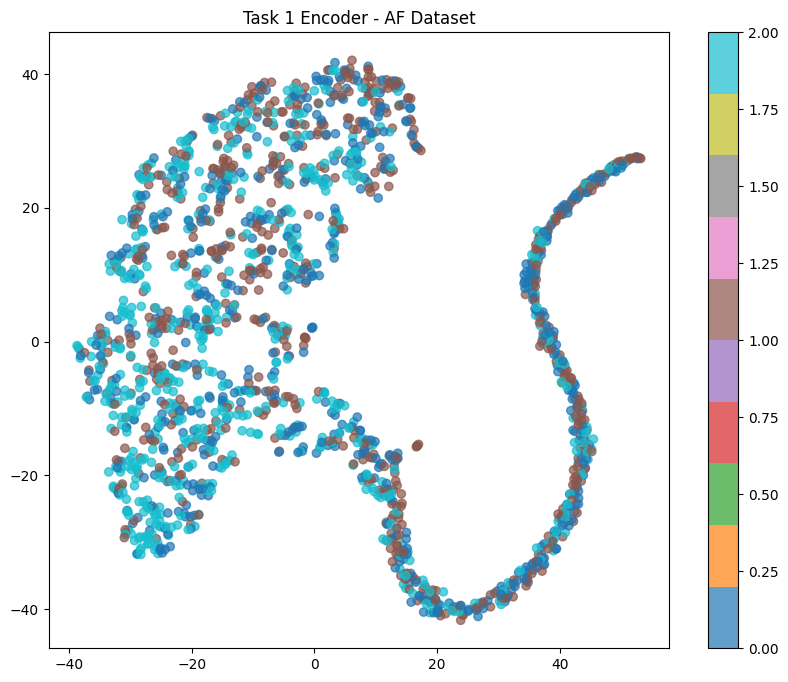

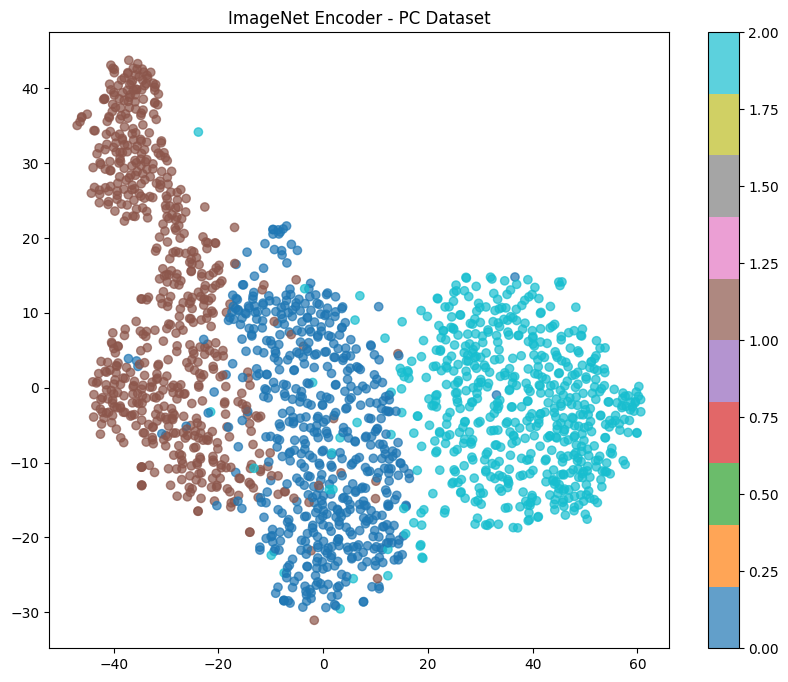

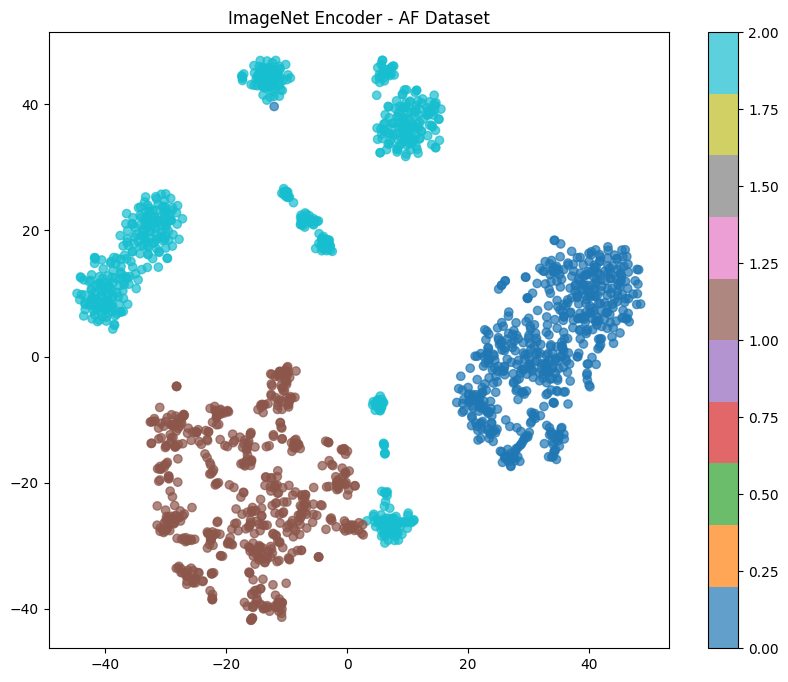

In [ ]:
# Visualize all scenarios
plot_tsne(features_PC_task1, labels_PC_task1, "Task 1 Encoder - PC Dataset")
plot_tsne(features_AF_task1, labels_AF_task1, "Task 1 Encoder - AF Dataset")
plot_tsne(features_PC_imagenet, labels_PC_imagenet, "ImageNet Encoder - PC Dataset")
plot_tsne(features_AF_imagenet, labels_AF_imagenet, "ImageNet Encoder - AF Dataset")

In [ ]:
# Task 1 Encoder on PC Dataset
# Train on the first half of the dataset
rf_classifier_PC_task1 = RandomForestClassifier(n_estimators=100, random_state=42)
midpoint = len(features_PC_task1) // 2
rf_classifier_PC_task1.fit(features_PC_task1[:midpoint], labels_PC_task1[:midpoint])

# Predict on the second half of the dataset
y_pred_PC_task1 = rf_classifier_PC_task1.predict(features_PC_task1[midpoint:])

# Generate classification report for the second half
print("Classification Report for PC Dataset (Task 1 Encoder):")
classification_report_PC_task1 = classification_report(labels_PC_task1[midpoint:], y_pred_PC_task1)
print(classification_report_PC_task1)

Classification Report for PC Dataset (Task 1 Encoder):
              precision    recall  f1-score   support

           0       0.79      0.79      0.79       302
           1       0.83      0.78      0.81       302
           2       0.91      0.97      0.94       296

    accuracy                           0.85       900
   macro avg       0.84      0.85      0.84       900
weighted avg       0.84      0.85      0.84       900



In [ ]:
# Task 1 Encoder on AF Dataset
# Train on the first half of the dataset
rf_classifier_AF_task1 = RandomForestClassifier(n_estimators=100, random_state=42)
midpoint_AF = len(features_AF_task1) // 2
rf_classifier_AF_task1.fit(features_AF_task1[:midpoint_AF], labels_AF_task1[:midpoint_AF])

# Predict on the second half of the dataset
y_pred_AF_task1 = rf_classifier_AF_task1.predict(features_AF_task1[midpoint_AF:])

# Generate classification report for the second half
print("Classification Report for AF Dataset (Task 1 Encoder):")
classification_report_AF_task1 = classification_report(labels_AF_task1[midpoint_AF:], y_pred_AF_task1)
print(classification_report_AF_task1)

Classification Report for AF Dataset (Task 1 Encoder):
              precision    recall  f1-score   support

           0       0.40      0.31      0.35       281
           1       0.45      0.56      0.50       297
           2       0.55      0.54      0.55       322

    accuracy                           0.47       900
   macro avg       0.47      0.47      0.46       900
weighted avg       0.47      0.47      0.47       900



In [ ]:
# ImageNet Encoder on PC Dataset
# Train on the first half of the dataset
rf_classifier_PC_imagenet = RandomForestClassifier(n_estimators=100, random_state=42)
midpoint_PC_imagenet = len(features_PC_imagenet) // 2
rf_classifier_PC_imagenet.fit(features_PC_imagenet[:midpoint_PC_imagenet], labels_PC_imagenet[:midpoint_PC_imagenet])

# Predict on the second half of the dataset
y_pred_PC_imagenet = rf_classifier_PC_imagenet.predict(features_PC_imagenet[midpoint_PC_imagenet:])

# Generate classification report for the second half
print("Classification Report for PC Dataset (ImageNet Encoder):")
classification_report_PC_imagenet = classification_report(labels_PC_imagenet[midpoint_PC_imagenet:], y_pred_PC_imagenet)
print(classification_report_PC_imagenet)

Classification Report for PC Dataset (ImageNet Encoder):
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       302
           1       0.96      0.95      0.96       302
           2       0.99      0.97      0.98       296

    accuracy                           0.96       900
   macro avg       0.96      0.96      0.96       900
weighted avg       0.96      0.96      0.96       900



In [ ]:
# ImageNet Encoder on AF Dataset
# Train on the first half of the dataset
rf_classifier_AF_imagenet = RandomForestClassifier(n_estimators=100, random_state=42)
midpoint_AF_imagenet = len(features_AF_imagenet) // 2
rf_classifier_AF_imagenet.fit(features_AF_imagenet[:midpoint_AF_imagenet], labels_AF_imagenet[:midpoint_AF_imagenet])

# Predict on the second half of the dataset
y_pred_AF_imagenet = rf_classifier_AF_imagenet.predict(features_AF_imagenet[midpoint_AF_imagenet:])

# Generate classification report for the second half
print("Classification Report for AF Dataset (ImageNet Encoder):")
classification_report_AF_imagenet = classification_report(labels_AF_imagenet[midpoint_AF_imagenet:], y_pred_AF_imagenet)
print(classification_report_AF_imagenet)

Classification Report for AF Dataset (ImageNet Encoder):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       281
           1       1.00      1.00      1.00       297
           2       1.00      1.00      1.00       322

    accuracy                           1.00       900
   macro avg       1.00      1.00      1.00       900
weighted avg       1.00      1.00      1.00       900



In [ ]:
# Directory to save the reports
output_dir = "./drive/MyDrive/Comp432_project/task_2/classification_reports" # for google collab
# output_dir = "/kaggle/working/classification_reports"
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it doesn't exist
# Save report function
def save_report(report, filename):
    with open(filename, "w") as f:
        json.dump(report, f, indent=4)
    print(f"Report saved to: {filename}")

# Saving the classification reports

# Task 1 Encoder on PC Dataset
save_report(classification_report_PC_task1, os.path.join(output_dir, "PC_Task1_Encoder.json"))

# Task 1 Encoder on AF Dataset
save_report(classification_report_AF_task1, os.path.join(output_dir, "AF_Task1_Encoder.json"))

# ImageNet Encoder on PC Dataset
save_report(classification_report_PC_imagenet, os.path.join(output_dir, "PC_ImageNet_Encoder.json"))

# ImageNet Encoder on AF Dataset
save_report(classification_report_AF_imagenet, os.path.join(output_dir, "AF_ImageNet_Encoder.json"))

Report saved to: ./drive/MyDrive/Comp432_project/task_2/classification_reports/PC_Task1_Encoder.json
Report saved to: ./drive/MyDrive/Comp432_project/task_2/classification_reports/AF_Task1_Encoder.json
Report saved to: ./drive/MyDrive/Comp432_project/task_2/classification_reports/PC_ImageNet_Encoder.json
Report saved to: ./drive/MyDrive/Comp432_project/task_2/classification_reports/AF_ImageNet_Encoder.json


In [ ]:
# Directory to save the models
models_dir = "./drive/MyDrive/Comp432_project/" # for google collab
# models_dir = "/kaggle/working/models"
os.makedirs(models_dir, exist_ok=True)  # Create the directory if it doesn't exist

# Save function for models
def save_model(model, filename):
    joblib.dump(model, filename)
    print(f"Model saved to: {filename}")

# Save the trained Random Forest models

# Task 1 Encoder on PC Dataset
save_model(rf_classifier_PC_task1, os.path.join(models_dir, "PC_Task1_Encoder_RF_Model.joblib"))

# Task 1 Encoder on AF Dataset
save_model(rf_classifier_AF_task1, os.path.join(models_dir, "AF_Task1_Encoder_RF_Model.joblib"))

# ImageNet Encoder on PC Dataset
save_model(rf_classifier_PC_imagenet, os.path.join(models_dir, "PC_ImageNet_Encoder_RF_Model.joblib"))

# ImageNet Encoder on AF Dataset
save_model(rf_classifier_AF_imagenet, os.path.join(models_dir, "AF_ImageNet_Encoder_RF_Model.joblib"))

Model saved to: ./drive/MyDrive/Comp432_project/PC_Task1_Encoder_RF_Model.joblib
Model saved to: ./drive/MyDrive/Comp432_project/AF_Task1_Encoder_RF_Model.joblib
Model saved to: ./drive/MyDrive/Comp432_project/PC_ImageNet_Encoder_RF_Model.joblib
Model saved to: ./drive/MyDrive/Comp432_project/AF_ImageNet_Encoder_RF_Model.joblib
